# EDA 2

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import json
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from dateutil.parser import parse
sns.set_style("darkgrid")
pd.set_option('display.max_columns', None)

In [2]:
# read
tags=pd.read_excel("../../data/meta data/tags relevantes.xlsx")
tags_cc=tags.tag.to_list()
dic={}
for i,j in zip(tags.tag,tags.description):
    dic[i]=j

In [4]:
# Se lee csv
cleaned=pd.read_csv('../../data/consolidated data/cleaned_15December2022.csv', parse_dates=['Timestamp'], index_col='Timestamp')
cleaned.sort_index(inplace=True)
cleaned.rename(columns=dic,inplace=True)
cleaned=cleaned[tags.description.to_list()].drop(columns=["sag mill expert system"])

### Matriz de nulls

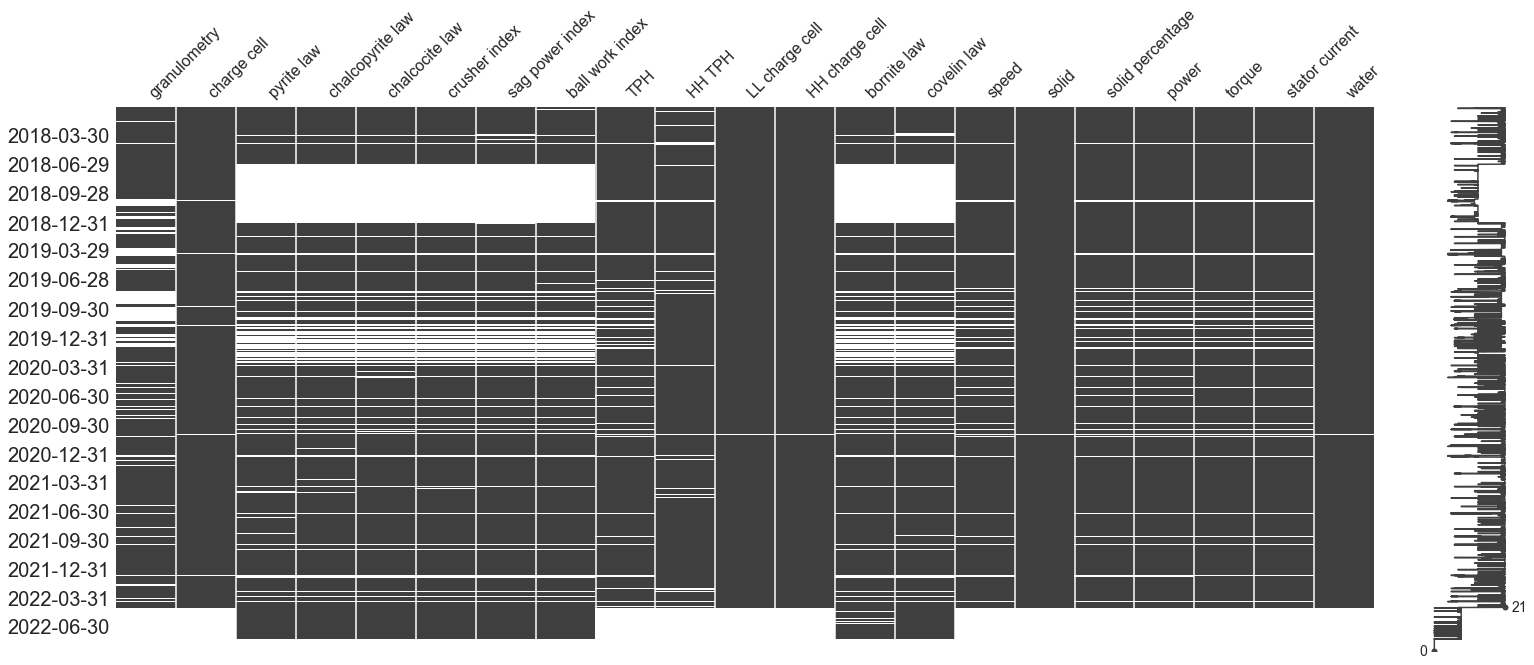

In [5]:
# Missings
msno.matrix(cleaned,freq='BQ')
plt.show()

### Visualización de señales en el tiempo

**Visualización completa de señales en el tiempo**

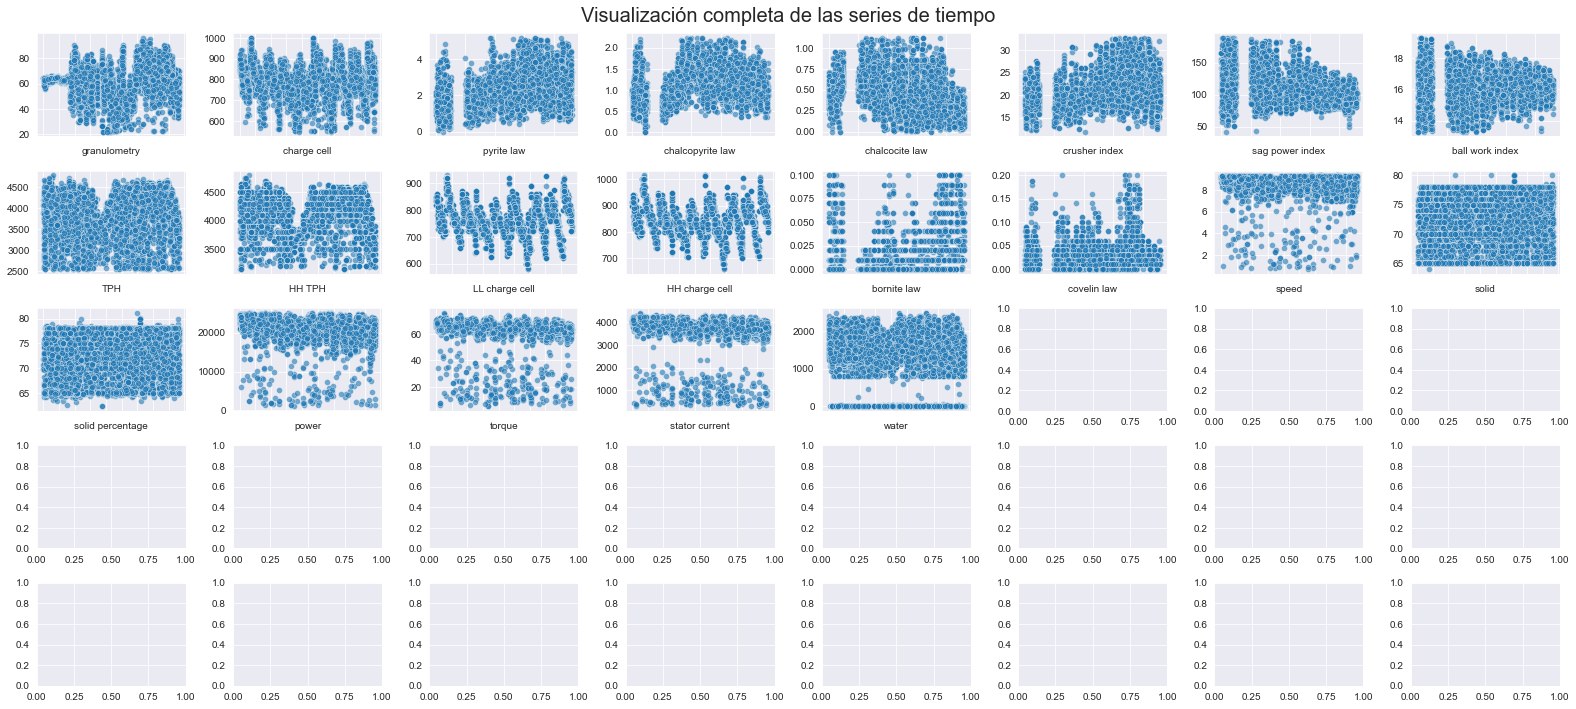

In [6]:
# Visualización completa de las series temporales

sample=cleaned.copy().sample(10000)
fig, ax = plt.subplots(5, 8, figsize=(22,10))
k = 0
for i in range(5):
    for j in range(8):
        try:
            sns.scatterplot(data=sample, x=sample.index, y=sample.columns[k], alpha=0.6, ax=ax[i, j])
            ax[i, j].set_ylabel('', fontsize = 10.0)
            ax[i, j].set_xlabel(sample.columns[k], fontsize = 10.0)
            ax[i, j].set_xticklabels('')
            k+=1
        except:
            pass
fig.suptitle('Visualización completa de las series de tiempo',size=20)
fig.tight_layout()


**Distribución de los datos**

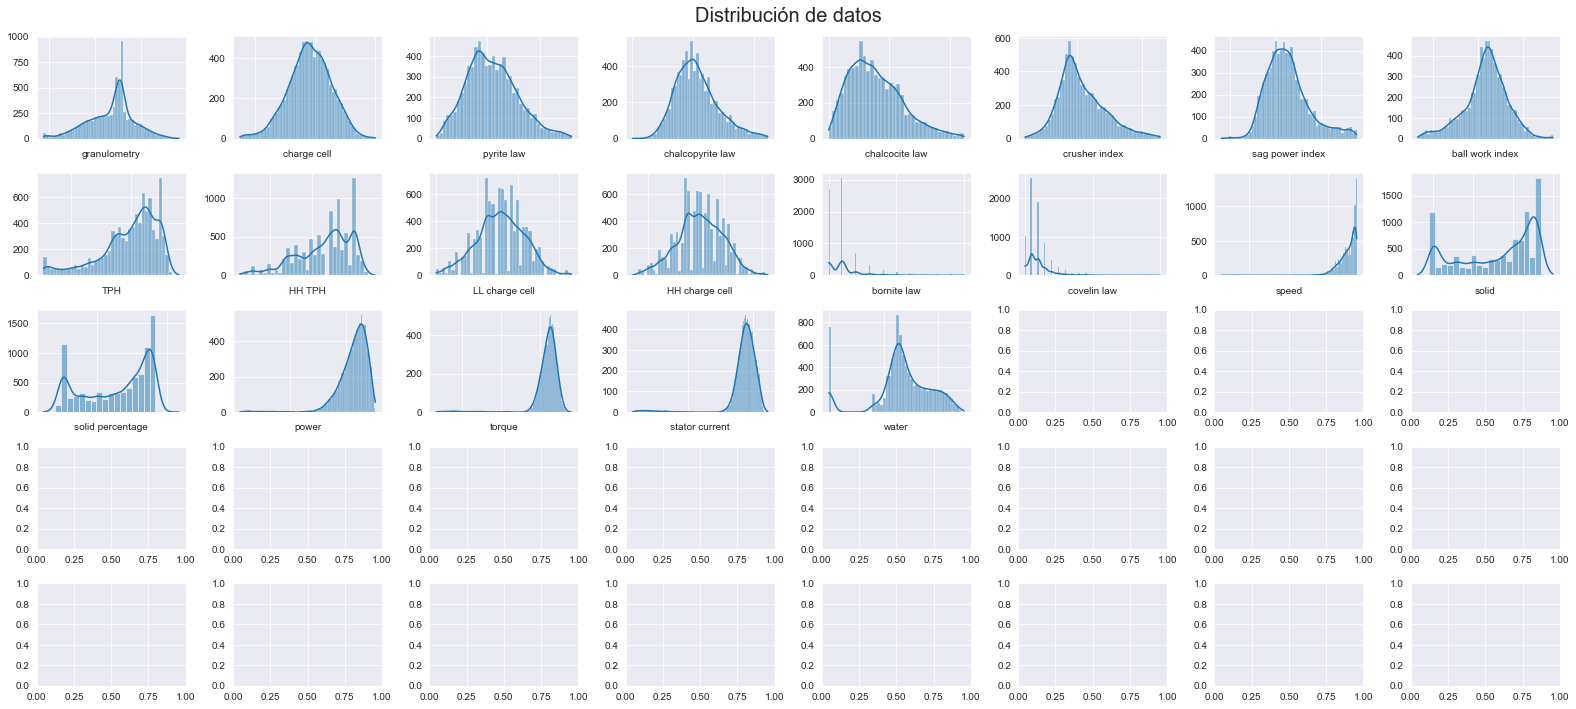

In [7]:
fig, ax = plt.subplots(5, 8, figsize=(22,10))
k = 0
for i in range(5):
    for j in range(8):
        try:
            sns.histplot(data=cleaned.sample(10000), x=cleaned.columns[k], kde=True, ax=ax[i, j])
            ax[i, j].set_ylabel('', fontsize = 10.0)
            ax[i, j].set_xlabel(cleaned.columns[k], fontsize = 10.0)
            ax[i, j].set_xticklabels('')
            k+=1
        except:
            pass
        
fig.suptitle('Distribución de datos',size=20)
fig.tight_layout()

**Correlación entre variables: Matriz de correlación**

In [8]:
# Matriz de correlación
# Corr
df_corr = cleaned.dropna().corr()

fig=px.imshow(df_corr,
          labels=dict(x="", y="", color="Correlation"),
          x=cleaned.columns,
          y=cleaned.columns,
          zmin=-1,
          zmax=1,
          )
fig.update_layout(width=1000, height=1000,title="Correlación entre variables")
fig.show()

In [9]:
corr_tph=pd.DataFrame(df_corr.abs().granulometry.sort_values(ascending=False))
top_corr=corr_tph[corr_tph.granulometry>=0.1]
top_corr

,granulometry
granulometry,1.000000
solid percentage,0.294507
solid,0.290870
crusher index,0.281472
power,0.263655
water,0.199062
speed,0.181443
chalcopyrite law,0.157560
torque,0.150711
stator current,0.147234


In [10]:
# Función que filtra tags por alta correlación
def corrkill(dataframe, features, corr_cut=0.4):

    df = dataframe[features]
    dfcorr = pd.DataFrame(np.triu(df.corr()), columns=df.columns, index=df.columns)
    dfcorr = dfcorr.stack().reset_index()
    dfcorr.columns = ['Feat1','Feat2','Val']
    dfcorr = dfcorr[~dfcorr['Val'].isin([0,1])]
    dfcorr = dfcorr[dfcorr['Val'].abs()>corr_cut]
    dfcorr["Val"]=dfcorr["Val"].abs()
    
    return list(dfcorr['Feat2']), dfcorr.sort_values(by="Val",ascending=False)

In [11]:
# Se obtienen tags altamente correlacionados y matriz que permite visualizar cuales son los par de tags altamente correlacionados
collinearity, table_cor=corrkill(cleaned,cleaned.columns)

In [13]:
# Tags altamente correlacionados
table_cor

,Feat1,Feat2,Val
221,LL charge cell,HH charge cell,0.996954
331,solid,solid percentage,0.980521
397,torque,stator current,0.962873
376,power,stator current,0.907571
311,speed,power,0.887301
375,power,torque,0.879705
313,speed,stator current,0.839981
31,charge cell,LL charge cell,0.807126
32,charge cell,HH charge cell,0.805137
312,speed,torque,0.775311


In [14]:
tags_control=['sag mill expert system', 'Limitado por Límite Alto de Tonelaje',
       'Optimizando tonelaje', 'Limitado por Peso',
       'Limitado por Corriente Bobina', 'Limitado por torque espesador 2',
       'Limitado por torque espesador 3', 'Limitado por Potencia Bolas 1',
       'Limitado por Potencia Bolas 2', 'Limitado por Pebbles',
       'Limitado por Corriente harnero', 'Limitado por Potencia SAG',
       'Limitado por limite bajo de tonelaje',
       'Limitado por Temperatura bobina', 'Limitado por presión espesador 2',
       'Limitado por presión espesador 3']

**Correlación entre variables: Pairplot**

In [15]:
tag_pairplot=[i for i in top_corr.index.to_list() if i not in tags_control]


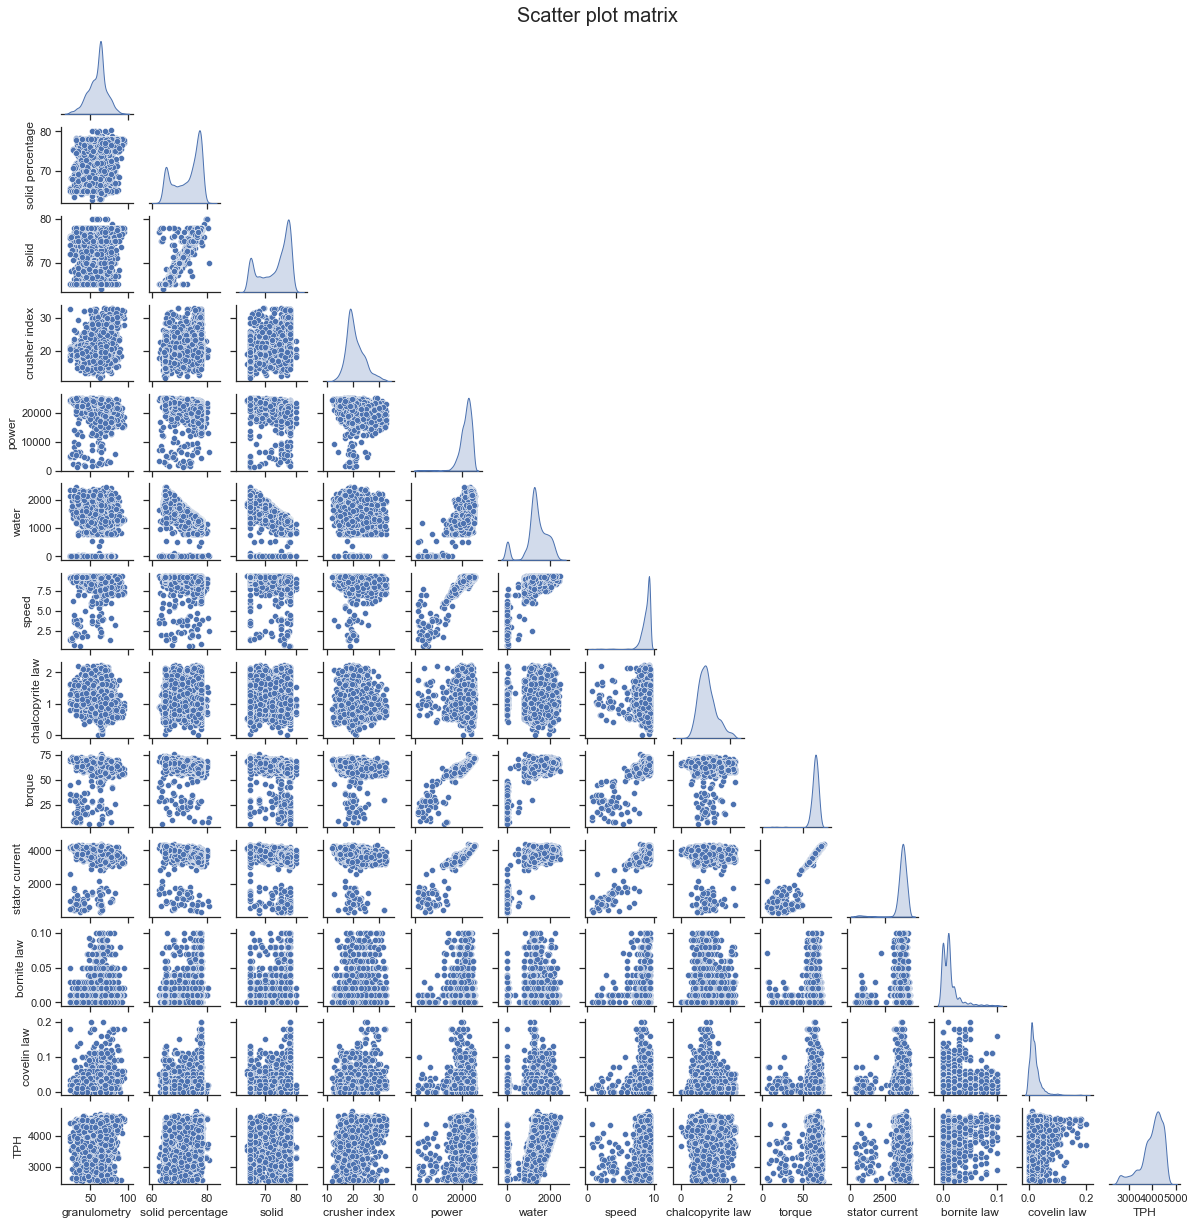

In [16]:
# Visualización de variables estandarizadas
MinMax=MinMaxScaler()
df_pairplot=cleaned[tag_pairplot].sample(5000)
matrix=MinMax.fit_transform(df_pairplot)
sns.set(style="ticks", color_codes=True)
g=sns.pairplot(df_pairplot,diag_kind="kde",height=1.3,corner=True)
g.fig.suptitle("Scatter plot matrix",position=(0.5, 1.01),fontsize=20)
plt.show()

**Subplots**

In [17]:
inicio_periodo=parse('2022-02-13 05:00:00')
fin_periodo=parse('2022-02-14 05:00:00')
data=cleaned.copy()[inicio_periodo:fin_periodo]
data.head()

,granulometry,charge cell,pyrite law,chalcopyrite law,chalcocite law,crusher index,sag power index,ball work index,TPH,HH TPH,LL charge cell,HH charge cell,bornite law,covelin law,speed,solid,solid percentage,power,torque,stator current,water
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-02-13 05:00:00,72.911023,871.370138,3.29,1.25,0.1,23.294,90.4616,16.9825,3813.668242,3900.0,860.0,940.0,0.01,0.01,9.310468,76.0,76.048487,21444.997434,61.127563,3638.331371,1202.189630
2022-02-13 05:01:00,72.156987,871.002630,3.29,1.25,0.1,23.294,90.4616,16.9825,3776.446368,3900.0,860.0,940.0,0.01,0.01,9.312231,76.0,75.943272,21439.286655,61.110182,3643.078147,1195.046615
2022-02-13 05:02:00,71.428951,872.513665,3.29,1.25,0.1,23.294,90.4616,16.9825,3790.390963,3900.0,860.0,940.0,0.01,0.01,9.306422,76.0,76.034012,21428.371942,61.026886,3635.104063,1194.627820
2022-02-13 05:03:00,70.600209,875.056577,3.29,1.25,0.1,23.294,90.4616,16.9825,3778.287558,3900.0,860.0,940.0,0.01,0.01,9.312750,76.0,75.977588,21451.469373,61.079909,3642.305742,1194.929335
2022-02-13 05:04:00,69.589860,877.236597,3.29,1.25,0.1,23.294,90.4616,16.9825,3793.537052,3900.0,860.0,940.0,0.01,0.01,9.309348,76.0,76.052708,21611.149831,61.552913,3665.109571,1194.406217


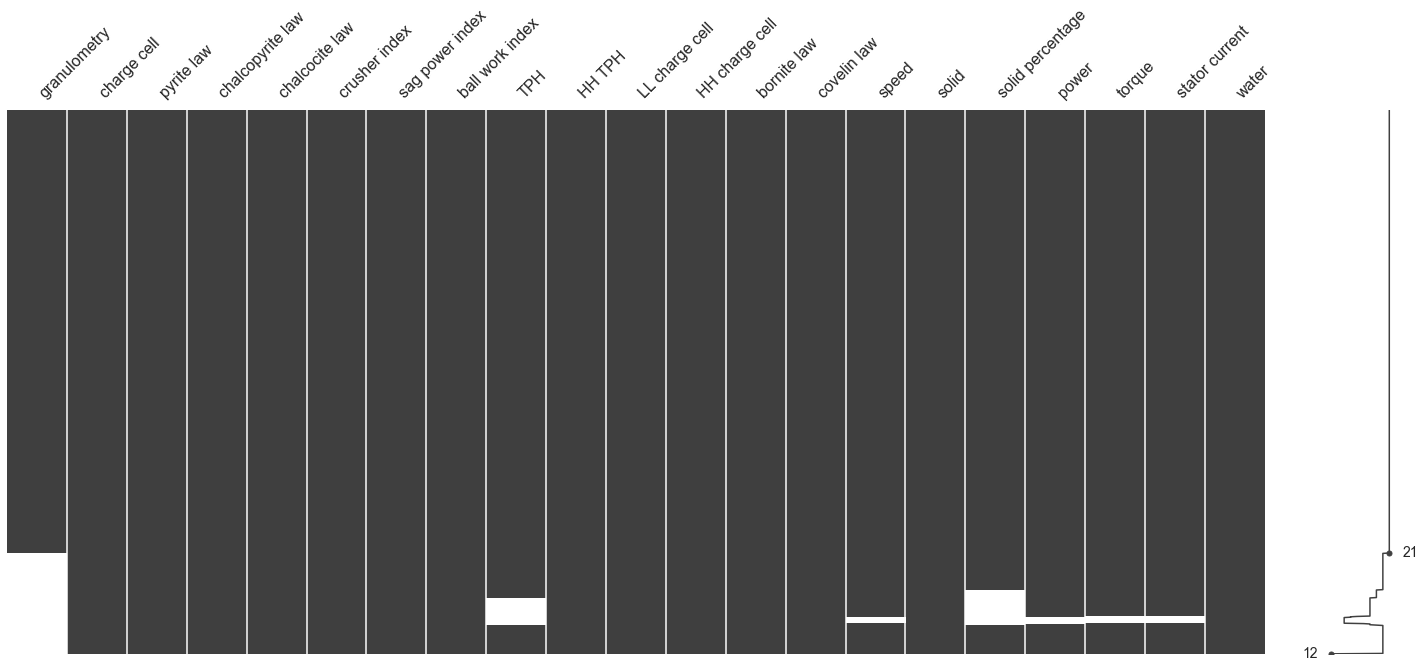

In [18]:
# Missings
msno.matrix(data,freq='BQ')
plt.show()

In [19]:
#read
tf = open("../../data/meta data/tag_dictionary.json", "r")
tag_dictionary = json.load(tf)
tags=pd.DataFrame(tag_dictionary)
tags

,tag,description,upper bound,lower bound,unit
0,CF:CVB007_S2.PNT.FOX,granulometry,None,None,None
1,CF:225.WIC8067.MEAS.FOX,charge cell,None,None,None
2,disp_ley_pirita,pyrite law,None,None,None
3,disp_ley_calcopirita,chalcopyrite law,None,None,None
4,disp_ley_calcosina,chalcocite law,None,None,None
5,disp_crusher_index,crusher index,None,None,None
6,disp_sag_power_index,sag power index,None,None,None
7,disp_ball_work_index,ball work index,None,None,None
8,CF:215.WIC1605A.MEAS.FOX,TPH,None,None,None
9,CF:EXPERTO:EXP_MS_A.MEAS_5.FOX,HH TPH,None,None,None


In [20]:
[i for i in top_corr.index.to_list() if i not in tags.description.to_list()]

['solid percentage',
 'solid',
 'power',
 'water',
 'speed',
 'torque',
 'stator current']

In [21]:
tags_restantes=[i for i in top_corr.index.to_list() if i not in tags.description.to_list()]
len(tags_restantes)

7

In [22]:
titulos=tuple(["Señal de TPH y HH TPH", "Celda de carga y HH/LL celda de carga","Granulometría F80","SPI","BWI & CI","Leyes mineralógicas"]+tags_restantes)
len(titulos)

13

In [23]:
fig = make_subplots(
    rows=5, cols=3,
    subplot_titles=titulos,
    #subplot_titles=tuple("TPH y HH TPH,"),
     #shared_xaxes=True
    )


fig.add_trace(go.Scatter(x=data.index, y=data['TPH'], ##FF6511
                    mode='lines',
                    name="TPH",line=dict(width=3, ),legendgroup = '1'),row=1, col=1)  

fig.add_trace(go.Scatter(x=data.index, y=data['HH TPH'], ##FF6511
                    mode='lines',
                    name="HH TPH",line=dict(width=3, ),legendgroup = '1'),row=1, col=1)  



fig.add_trace(go.Scatter(x=data.index, y=data['charge cell'], 
                    mode='lines',
                    name="Charge cell",line=dict(width=3, ),legendgroup = '1'),row=1, col=2)  



fig.add_trace(go.Scatter(x=data.index, y=data['LL charge cell'], ##FF6511
                    mode='lines',
                    name="LL charge cell",line=dict(width=3,),legendgroup = '1'),row=1, col=2)  

fig.add_trace(go.Scatter(x=data.index, y=data['HH charge cell'], ##FF6511
                    mode='lines',
                    name="HH charge cell",line=dict(width=3,),legendgroup = '1'),row=1, col=2)  



fig.add_trace(go.Scatter(x=data.index, y=data['granulometry'], ##FF6511
                    mode='lines',
                    name='granulometry',line=dict(width=3,),legendgroup = '1'),row=1, col=3)  


fig.add_trace(go.Scatter(x=data.index, y=data['sag power index'], ##FF6511
                    mode='lines',
                    name="sag power index",line=dict(width=3, ),legendgroup = '1'),row=2, col=1)  


fig.add_trace(go.Scatter(x=data.index, y=data['ball work index'], ##FF6511
                    mode='lines',
                    name="ball work index",line=dict(width=3, ),legendgroup = '1'),row=2, col=2)  


fig.add_trace(go.Scatter(x=data.index, y=data['crusher index'], ##FF6511
                    mode='lines',
                    name="crusher index",line=dict(width=3, ),legendgroup = '1'),row=2, col=2)  


fig.add_trace(go.Scatter(x=data.index, y=data['pyrite law'], ##FF6511
                    mode='lines',
                    name="pyrite law",line=dict(width=3, ),legendgroup = '1'),row=2, col=3)  

fig.add_trace(go.Scatter(x=data.index, y=data['chalcopyrite law'], ##FF3511
                    mode='lines',
                    name="chalcopyrite law",line=dict(width=3, ),legendgroup = '1'),row=2, col=3)  

fig.add_trace(go.Scatter(x=data.index, y=data['chalcocite law'], ##FF3511
                    mode='lines',
                    name="chalcocite law",line=dict(width=3, ),legendgroup = '1'),row=2, col=3)  

fig.add_trace(go.Scatter(x=data.index, y=data['covelin law'], ##FF3511
                    mode='lines',
                    name="covelin law",line=dict(width=3, ),legendgroup = '1'),row=2, col=3)  

fig.add_trace(go.Scatter(x=data.index, y=data['bornite law'], ##FF3511
                    mode='lines',
                    name="bornite law",line=dict(width=3, ),legendgroup = '1'),row=2, col=3)  



for i in range(1,6):
   for j in range(1,4):
        fig.update_xaxes(tickformat="%H:%M",row=i, col=j)


k=0
for i in range(3,6):
   for j in range(1,4):
       try:
           fig.add_trace(go.Scatter(x=data.index, y=data[tags_restantes[k]], ##FF6511
                       mode='lines',
                       name=tags_restantes[k],line=dict(width=3, ),legendgroup = '1'),row=i, col=j) 

           k+=1
       except:
           pass
     



fig.update_layout(height=1000, width=2000, title_text="Análisis temporal de señales"#,xaxis6_rangeslider_visible=True
,#template="plotly_dark"
)

fig.show()